<a href="https://colab.research.google.com/github/Alexey1998-ml/Computer-vision/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import cv2

import albumentations as A
import copy
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
DIR_INPUT = 'drive/My Drive/digit recognizer'
DIR_TRAIN = f'{DIR_INPUT}/train.csv'
DIR_TEST = f'{DIR_INPUT}/test.csv'

In [2]:
train_df = pd.read_csv(DIR_TRAIN)
test_df = pd.read_csv(DIR_TEST)

In [3]:
train_df, valid_df = train_test_split(train_df, test_size = 0.1, stratify = train_df['label'])

In [4]:
class DigitRecognizerDataset(Dataset):

  def __init__(self, df, target_column = 'label', transforms = None):
    super().__init__()
    self.df = df
    self.image_columns = df.columns.drop(target_column)
    self.target_column = target_column
    self.transforms = transforms

  def __getitem__(self, idx):
    image = np.array(self.df[self.image_columns].iloc[idx]).reshape(28, 28) / 255.
    label = self.df.iloc[idx][self.target_column] 
    if self.transforms:
      image = self.transforms(image = image)
    return image, label
  
  def __len__(self):
    return len(self.df)

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))
    
def get_train_transform():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit = 0.05, scale_limit=0.05, rotate_limit=10, p = 0.05),
        A.Rotate(limit = 10, p = 0.05)
        # A.GridDistortion(num_steps = 1, p = 0.05),
        # A.Blur(blur_limit=1, p = 0.05)    
    ])

def get_valid_transform():
    return A.Compose([
        A.ShiftScaleRotate(shift_limit = 0.05, scale_limit=0.05, rotate_limit=10, p = 0.0),

    ])


train_dataset = DigitRecognizerDataset(train_df, transforms = get_train_transform())
valid_dataset = DigitRecognizerDataset(valid_df, transforms = get_valid_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 128,
    shuffle = True,
    collate_fn = collate_fn)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 64,
    shuffle = True,
    collate_fn = collate_fn)

In [6]:
class CNNResBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size, padding = 1):
    super(CNNResBlock, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding= padding)
    self.batchnorm1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, padding= padding)
    self.batchnorm2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.cnn3 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, padding= padding)
    self.batchnorm3 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.cnn4 = nn.Conv2d(out_channels, out_channels, kernel_size = kernel_size, stride = 2, padding = 1)
    self.batchnorm4 = nn.BatchNorm2d(out_channels)
    self.dropout = nn.Dropout2d(0.3)


  def forward(self, input):
    
    input1 = self.cnn1(input)
    input1 = self.batchnorm1(input1)
    input1 = self.relu(input1)

    input2 = self.cnn2(input1)
    input2 = self.batchnorm2(input2)
    input2 = self.relu(input2)
    input2 = self.dropout(input2)
    
    input3 = self.cnn3(input2)
    input3 = self.batchnorm3(input3)
    input3 = self.relu(input3)

    input3 += input1

    out = self.cnn4(input3)
    out = self.batchnorm4(out)
    out = self.relu(out)
    return out



In [7]:
class CNNBlock(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size, padding = 0):
    super(CNNBlock, self).__init__()
    self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding= padding)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.relu = nn.LeakyReLU()


  def forward(self, input):
    input = self.cnn(input)
    input = self.batchnorm(input)
    out = self.relu(input)
    return out

In [8]:
class Model(nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    self.cnn1 = CNNBlock(in_channels = 1, out_channels = 32, kernel_size = 3)
    self.cnn2 = CNNBlock(in_channels = 32, out_channels = 32, kernel_size = 3)
    self.cnn3 = CNNBlock(in_channels = 32, out_channels = 64, kernel_size = 3)
    self.cnn4 = CNNBlock(in_channels = 64, out_channels = 64, kernel_size = 3)
    self.cnn5 = CNNBlock(in_channels = 64, out_channels = 128, kernel_size = 3)


    self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    self.relu = nn.ReLU()
    self.linear1 = nn.Linear(512, 100)
    self.linear2 = nn.Linear(100, 10)
    self.softmax = nn.Softmax(-1)
    self.drop2d = nn.Dropout2d(0.4) 
    self.drop1d = nn.Dropout(.4)
    self.batchnorm1d = nn.BatchNorm1d(100)

  def forward(self, input):
    input = input.unsqueeze(1)
    
    input = self.cnn1(input)
    input = self.cnn2(input)
    input = self.drop2d(input)
    input = self.maxpool1(input) 


    input = self.cnn3(input)
    input = self.cnn4(input)
    input = self.drop2d(input)
    input = self.maxpool2(input)
    
    input = self.cnn5(input)
    input = torch.flatten(input, start_dim = 1, )

    input = self.relu(self.linear1(input))
    xgb = copy.copy(input)
    input = self.batchnorm1d(input)
    input = self.drop1d(input)
    input = self.linear2(input)
    out = self.softmax(input)
    return out, xgb

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

In [ ]:
model = Model()
model.to(device)
# def init_weights(m):
#     for name, param in m.named_parameters():
#       nn.init.uniform_(param, -0.08, 0.08)
# model.apply(init_weights)

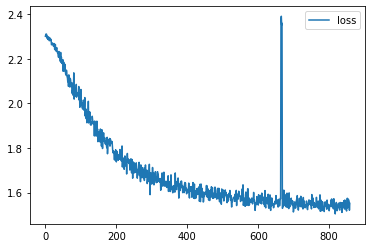

loss: 1.5517725944519043
accuracy train: 0.96484375
accuracy valid: 0.975
lr: 5e-05


KeyboardInterrupt: ignored

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr = 10**-4)
# optimizer = torch.optim.SGD(model.parameters(), lr = 10**-4)
loss_function = nn.CrossEntropyLoss()
# scheduler = Scheduler(optimizer)
# history_loss = []
# history_train = []
# history_val = []
# max_val = 0
epochs = 5
for epoch in range(epochs):
  for i, (images_dict, labels) in enumerate(train_data_loader):
    model.train()
    images = list(image['image'] for image in images_dict)
    images = torch.FloatTensor(images).to(device)
    labels = torch.LongTensor(labels).to(device)
    predicts, _ = model(images)
    loss = loss_function(predicts, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    history_loss.append(loss)
    if i % 5 == 0:
      history_train.append(evaluate(train_data_loader))
      history_val.append(evaluate(valid_data_loader))
      print(f'i: {i}')
      if history_val[-1] > max_val:
        max_val = history_val[-1]
        best_model = copy.deepcopy(model)
      # scheduler.step(board = history_train[-1], i = i)
    clear_output(True)
    plt.plot(history_loss, label = 'loss')
    plt.legend()
    plt.show()
    print(f'loss: {loss}')
    print(f'accuracy train: {np.mean(history_train[-10:])}')
    print(f'accuracy valid: {np.mean(history_val[-10:])}')
    print(f'lr: {optimizer.param_groups[0]["lr"]}')

In [ ]:
def evaluate (data_loader):
  model.eval()
  input_dict, labels = next(iter(data_loader))
  input = list(image['image'] for image in input_dict)
  input = torch.FloatTensor(input).to(device)
  predicts, _ = model(input)
  return accuracy_score(labels, np.argmax(predicts.cpu().detach().numpy(), axis = 1))

In [ ]:
class Scheduler:

  def __init__(self, optimizer, p = 0.005):
    self.optimizer = optimizer
    self.p = p

  def step(self, board, i, threshold_i = 50, threshold = 0.5, k_up = 1.1, k_down = 0.99):
    if board < threshold and i < threshold_i:
      print('Up')
      k = 1.1 + (0.5 - board) * 0.1
    else:
      rnd = random.random()
      if rnd < self.p:
        k = k_up
      else:
        print('down')
        k = k_down  
    for idx_group in range(len(self.optimizer.param_groups)):
      self.optimizer.param_groups[0]['lr'] *= k  
    print(f'k:{k}')    

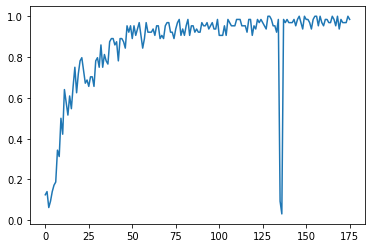

In [ ]:
plt.plot(history_val)

In [ ]:
model = best_model

In [ ]:
torch.save(model.state_dict(), f'{DIR_INPUT}/model.pth')

In [ ]:
model.load_state_dict(torch.load(f'{DIR_INPUT}/model.pth'))
model.to(device)

Model(
  (cnn1): CNNBlock(
    (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (cnn2): CNNBlock(
    (cnn): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (cnn3): CNNBlock(
    (cnn): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (cnn4): CNNBlock(
    (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01)
  )
  (cnn5): CNNBlock(
    (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (batchno

In [ ]:
def get_tensor_from_df(df):
  df = df / 255.
  df_array = df.values.reshape(-1,28,28)
  tensor = torch.FloatTensor(df_array).to(device)
  return tensor

In [ ]:
def make_submit_file(test_df, labels = None):
  if labels is None:
    predicts, _ = get_predict(test_df)
    labels = np.argmax(predicts, axis = 1)
  labels = pd.Series(labels, name = 'Label')
  submission = pd.concat([pd.Series(range(1,test_df.shape[0] + 1), name = 'ImageId'), labels], axis = 1)
  submission.to_csv(f'{DIR_INPUT}/submission.csv', index = False)

In [ ]:
def get_predict(df):
  columns = list(filter(lambda x: x[:5] == 'pixel', df.columns))
  tensor = get_tensor_from_df(df[columns])
  model.eval()
  predicts, features = model(tensor[:1000])
  predicts = predicts.cpu().detach().numpy()
  features = features.cpu().detach().numpy()
  end_of_range = df.shape[0] //1000 + 2
  for i in range(2, end_of_range):
    predicts = np.concatenate([predicts, model(tensor[1000 * (i - 1):1000 * i])[0].cpu().detach().numpy()], axis = 0)
    features = np.concatenate([features, model(tensor[1000 * (i - 1):1000 * i])[1].cpu().detach().numpy()], axis = 0)
  return predicts, features

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, )
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

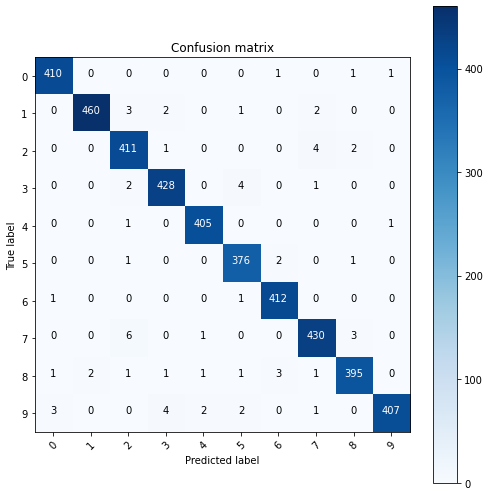

In [ ]:
 plot_confusion_matrix(confusion_matrix(valid_df['label'], np.argmax(get_predict(valid_df)[0], axis = 1)), 
                       classes = range(10))

In [ ]:
def show_photo(df, idx):
  plt.imshow(df[df.columns.drop('label')].iloc[idx].values.reshape(28,28), cmap = 'gray')

class MissPredicts:

  def __init__(self, df, target_column = 'label'):
    predicts, _ = get_predict(df)
    self.predicts = np.argmax(predicts, axis = 1)
    self.df_miss_predicts = df.loc[df[target_column] != self.predicts]
    self.target_column = target_column

  def __getitem__(self, idx):
    show_photo(self.df_miss_predicts, idx)
    true_idx = self.df_miss_predicts[self.target_column].iloc[idx]
    predict_idx = self.predicts[idx]
    print(f'True: {true_idx}')
    print(f'Predict: {predict_idx}')
  

  def __len__(self):
    return self.df_miss_predicts.shape[0]

In [ ]:
miss_predicts = MissPredicts(valid_df)

In [ ]:
def add_features(df):
  df = df.reset_index().drop('index', axis = 1)
  predicts = get_predict(df)[1]
  pd_feature = pd.DataFrame(predicts, columns = [f'feature_{i}' for i in range(predicts.shape[1])])
  return pd.concat([df, pd_feature], axis = 1)

In [ ]:
train_df = add_features(train_df)
valid_df = add_features(valid_df)
# test_df = add_features(test_df)

In [ ]:
forest = RandomForestClassifier()

In [ ]:
tree_columns = list(filter(lambda x: x[:8] == 'feature_', train_df.columns))

In [ ]:
forest.fit(train_df[tree_columns], train_df['label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
accuracy_score(valid_df['label'], forest.predict(valid_df[tree_columns]))

0.9804761904761905

In [ ]:
accuracy_score(train_df['label'], forest.predict(train_df[tree_columns]))

1.0

In [ ]:
accuracy_score(valid_df['label'], np.argmax(get_predict(valid_df)[0] + forest.predict_proba(valid_df[tree_columns]), axis = 1))

0.9742857142857143

In [ ]:
accuracy_score(valid_df['label'], np.argmax(get_predict(valid_df)[0], axis = 1))

0.964047619047619

In [ ]:
len(tree_columns)

100

In [ ]:
dtrain = xgb.DMatrix(train_df[tree_columns], train_df['label'])
dfvalid = xgb.DMatrix(valid_df[tree_columns], valid_df['label'])

In [ ]:
params = {
    'max_depth': 3,
    'silent': 1,
    'eta': 0.3,
    'subsample': 0.7,
    'colsample_bytree': 0.7
}
params['num_class'] = 10
params['objective'] = 'multi:softprob'
num_rounds = 50

In [ ]:
watchlist  = [(dfvalid,'test'), (dtrain,'train')] 
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-merror:0.069286	train-merror:0.06172
[1]	test-merror:0.040952	train-merror:0.035688
[2]	test-merror:0.038333	train-merror:0.033386
[3]	test-merror:0.034048	train-merror:0.030476
[4]	test-merror:0.030952	train-merror:0.028228
[5]	test-merror:0.029524	train-merror:0.027143
[6]	test-merror:0.029048	train-merror:0.025926
[7]	test-merror:0.027381	train-merror:0.025159
[8]	test-merror:0.027143	train-merror:0.02381
[9]	test-merror:0.026905	train-merror:0.022884
[10]	test-merror:0.025952	train-merror:0.022037
[11]	test-merror:0.025952	train-merror:0.021323
[12]	test-merror:0.025952	train-merror:0.020608
[13]	test-merror:0.026429	train-merror:0.020026
[14]	test-merror:0.025	train-merror:0.019471
[15]	test-merror:0.024762	train-merror:0.018915
[16]	test-merror:0.024524	train-merror:0.01828
[17]	test-merror:0.024048	train-merror:0.017593
[18]	test-merror:0.022857	train-merror:0.017328
[19]	test-merror:0.022619	train-merror:0.016455
[20]	test-merror:0.022857	train-merror:0.01582
[21]	test

In [ ]:
accuracy_score(valid_df['label'], np.argmax(xgb_model.predict(dfvalid), axis = 1))

0.9804761904761905

In [ ]:
accuracy_score(valid_df['label'], np.argmax(xgb_model.predict(dfvalid) + get_predict(valid_df)[0] + forest.predict_proba(valid_df[tree_columns]), axis = 1))

0.98

In [ ]:
make_submit_file(test_df)

In [ ]:
images, labels = next(iter(train_data_loader))

In [ ]:
images[1]['image'].shape

(28, 28)

In [ ]:
transform = A.Compose([
                       A.
])
image = images[1]['image'] * 255
augment = transform(image = image)
fig, ax = plt.subplots(1,2)
ax[0].imshow(image, cmap = 'gray')
ax[0].set_title('original')
ax[1].imshow(augment['image'], cmap = 'gray')
ax[1].set_title('transform')
plt.show

NotImplementedError: ignored

In [ ]:
A.ShiftScaleRotate()
A.GridDistortion()